# Step 1: Data Preparation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from pandas.plotting import autocorrelation_plot

import scipy.stats as stats

from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from yahoofinancials import YahooFinancials

### Download Gold data and other predictors data using YahooFinancials packages

In [2]:
ticker_details = pd.read_excel(r"C:\Users\ASUS\Downloads\Ticker List.xlsx")
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

In [4]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2022-12-18"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

In [5]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = pd.merge(values, df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)

In [127]:
values_spare = values.copy()

In [7]:
values.isnull().sum()

Date          0
GC=F        120
SI=F        121
CL=F        118
^GSPC       118
^RUT        118
ZN=F        120
ZT=F        118
PL=F        137
HG=F        119
DX=F        116
^VIX        118
EEM         118
EURUSD=X    403
^N100        65
^IXIC       118
dtype: int64

In [8]:
names.insert(0,'Date')
values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(3381, 16)
Date                         0
Gold                       120
Silver                     121
Crude Oil                  118
S&P500                     118
Russel 2000 Index          118
10 Yr US T-Note futures    120
2 Yr US T-Note Futures     118
Platinum                   137
Copper                     119
Dollar Index               116
Volatility Index           118
MSCI EM ETF                118
Euro USD                   403
Euronext100                 65
Nasdaq                     118
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
3376,2022-12-12,1780.500000,23.219999,73.169998,3990.560059,1818.609985,113.593750,102.472656,1021.000000,3.7985,105.103996,25.000000,38.316002,1.052222,1269.150024,11143.740234
3377,2022-12-13,1813.900024,23.801001,75.389999,4019.649902,1832.359985,114.531250,102.800781,1051.900024,3.8395,103.943001,22.549999,38.590000,1.054174,1289.300049,11256.809570
3378,2022-12-14,1807.500000,23.945999,77.279999,3995.320068,1820.449951,114.453125,102.816406,1051.699951,3.8750,103.738998,21.139999,38.610001,1.062665,1285.979980,11170.889648
3379,2022-12-15,1777.199951,23.128000,76.110001,3895.750000,1774.609985,114.703125,102.804688,1026.199951,3.7630,104.531998,22.830000,37.720001,1.067635,1248.650024,10810.530273
3380,2022-12-16,1790.000000,23.150999,74.290001,3852.360107,1763.420044,114.671875,102.902344,1013.000000,3.7615,104.661003,22.620001,37.830002,1.064056,1234.589966,10705.410156


### Impute missing values

In [9]:
#Front filling the NaN values in the data set
values = values.fillna(method="ffill",axis=0)
values = values.fillna(method="bfill",axis=0)
values.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [10]:
values

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
0,2010-01-01,1117.699951,17.440001,81.510002,1132.989990,640.099976,115.531250,108.257812,1517.300049,3.3880,77.830002,20.040001,32.683075,1.438994,696.989990,2308.419922
1,2010-01-04,1117.699951,17.440001,81.510002,1132.989990,640.099976,115.531250,108.257812,1517.300049,3.3880,77.830002,20.040001,32.683075,1.442398,696.989990,2308.419922
2,2010-01-05,1118.099976,17.781000,81.769997,1136.520020,638.489990,116.203125,108.414062,1530.800049,3.3960,77.849998,19.350000,32.920311,1.436596,697.570007,2308.709961
3,2010-01-06,1135.900024,18.163000,83.180000,1137.140015,637.950012,115.968750,108.445312,1552.199951,3.4775,77.654999,19.160000,32.989162,1.440403,698.270020,2301.090088
4,2010-01-07,1133.099976,18.333000,82.660004,1141.689941,641.969971,115.843750,108.390625,1553.000000,3.4115,78.105003,19.059999,32.797874,1.431803,697.760010,2300.050049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3376,2022-12-12,1780.500000,23.219999,73.169998,3990.560059,1818.609985,113.593750,102.472656,1021.000000,3.7985,105.103996,25.000000,38.316002,1.052222,1269.150024,11143.740234
3377,2022-12-13,1813.900024,23.801001,75.389999,4019.649902,1832.359985,114.531250,102.800781,1051.900024,3.8395,103.943001,22.549999,38.590000,1.054174,1289.300049,11256.809570
3378,2022-12-14,1807.500000,23.945999,77.279999,3995.320068,1820.449951,114.453125,102.816406,1051.699951,3.8750,103.738998,21.139999,38.610001,1.062665,1285.979980,11170.889648
3379,2022-12-15,1777.199951,23.128000,76.110001,3895.750000,1774.609985,114.703125,102.804688,1026.199951,3.7630,104.531998,22.830000,37.720001,1.067635,1248.650024,10810.530273


### Cleaned dataset before implementing models

In [11]:
# Co-ercing numeric type to all columns except Date
cols=values.columns.drop('Date')
values[cols] = values[cols].apply(pd.to_numeric,errors='coerce').round(decimals=2)
values.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
3376,2022-12-12,1780.5,23.22,73.17,3990.56,1818.61,113.59,102.47,1021.0,3.80,105.10,25.00,38.32,1.05,1269.15,11143.74
3377,2022-12-13,1813.9,23.80,75.39,4019.65,1832.36,114.53,102.80,1051.9,3.84,103.94,22.55,38.59,1.05,1289.30,11256.81
3378,2022-12-14,1807.5,23.95,77.28,3995.32,1820.45,114.45,102.82,1051.7,3.88,103.74,21.14,38.61,1.06,1285.98,11170.89
3379,2022-12-15,1777.2,23.13,76.11,3895.75,1774.61,114.70,102.80,1026.2,3.76,104.53,22.83,37.72,1.07,1248.65,10810.53
3380,2022-12-16,1790.0,23.15,74.29,3852.36,1763.42,114.67,102.90,1013.0,3.76,104.66,22.62,37.83,1.06,1234.59,10705.41


In [12]:
values['Gold']

0       1117.7
1       1117.7
2       1118.1
3       1135.9
4       1133.1
         ...  
3376    1780.5
3377    1813.9
3378    1807.5
3379    1777.2
3380    1790.0
Name: Gold, Length: 3381, dtype: float64

In [13]:
values.set_index('Date', inplace=True)

# Step 2: Summary data

<AxesSubplot: xlabel='Date', ylabel='Gold'>

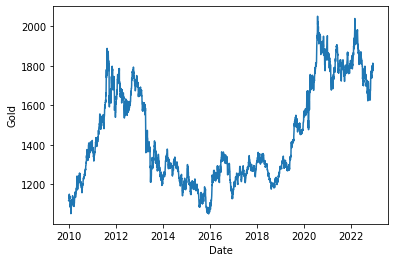

In [14]:
sns.lineplot(data=values, x="Date", y="Gold")

In [15]:
values['Gold'].describe()

count    3381.000000
mean     1448.066341
std       248.723489
min      1050.800000
25%      1245.000000
50%      1340.100000
75%      1684.600000
max      2051.500000
Name: Gold, dtype: float64

In [16]:
values_original = values.copy()

In [17]:
values_sample = values[values.index > '2019-01-01']

In [18]:
values_sample

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
Date,,,,,,,,,,,,,,,
2019-01-02,1281.0,15.54,46.54,2510.03,1355.91,122.19,106.12,799.1,2.62,96.42,23.22,35.88,1.15,910.35,6665.94
2019-01-03,1291.8,15.71,47.09,2447.89,1330.83,123.16,106.37,794.5,2.57,95.88,25.45,35.23,1.13,897.45,6463.50
2019-01-04,1282.7,15.69,47.96,2531.94,1380.75,122.30,106.16,822.0,2.65,95.75,21.38,36.36,1.14,921.30,6738.86
2019-01-07,1286.8,15.67,48.52,2549.69,1405.37,122.05,106.08,818.4,2.64,95.23,21.40,36.45,1.14,919.66,6823.47
2019-01-08,1283.2,15.63,49.78,2574.41,1426.55,121.75,105.95,816.5,2.66,95.48,20.47,36.58,1.15,929.30,6897.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,1780.5,23.22,73.17,3990.56,1818.61,113.59,102.47,1021.0,3.80,105.10,25.00,38.32,1.05,1269.15,11143.74
2022-12-13,1813.9,23.80,75.39,4019.65,1832.36,114.53,102.80,1051.9,3.84,103.94,22.55,38.59,1.05,1289.30,11256.81
2022-12-14,1807.5,23.95,77.28,3995.32,1820.45,114.45,102.82,1051.7,3.88,103.74,21.14,38.61,1.06,1285.98,11170.89


<AxesSubplot: xlabel='Date', ylabel='Gold'>

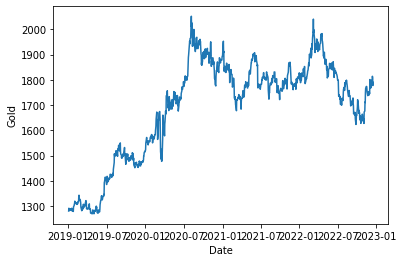

In [19]:
sns.lineplot(data=values_sample, x="Date", y="Gold")

# Step 3: Split data into train set and test set

In [52]:
train_ratio = 0.8

In [21]:
df_train = values_sample['Gold'].iloc[:int(train_ratio*len(values_sample['Gold']))]
df_test = values_sample['Gold'].iloc[int(train_ratio*len(values_sample['Gold'])):]

In [22]:
df_train

Date
2019-01-02    1281.0
2019-01-03    1291.8
2019-01-04    1282.7
2019-01-07    1286.8
2019-01-08    1283.2
               ...  
2022-02-24    1925.1
2022-02-25    1886.5
2022-02-28    1899.4
2022-03-01    1942.4
2022-03-02    1920.9
Name: Gold, Length: 826, dtype: float64

In [23]:
df_test

Date
2022-03-03    1934.4
2022-03-04    1965.1
2022-03-07    1993.9
2022-03-08    2040.1
2022-03-09    1985.9
               ...  
2022-12-12    1780.5
2022-12-13    1813.9
2022-12-14    1807.5
2022-12-15    1777.2
2022-12-16    1790.0
Name: Gold, Length: 207, dtype: float64

<AxesSubplot: xlabel='Date'>

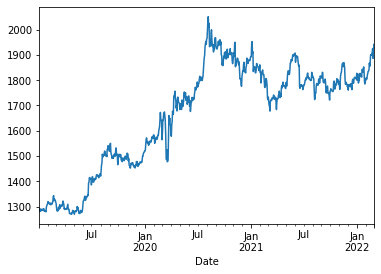

In [24]:
df_train.plot()

<AxesSubplot: xlabel='Date'>

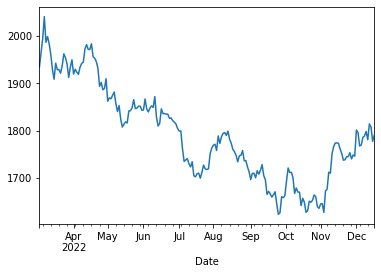

In [25]:
df_test.plot()

# Step 4: Implement Baseline model

## Step 4.1:Naive Forecast with trend-adjusted

In [26]:
df_tho_xu_the = values_sample.Gold.copy()

In [27]:
df_tho_xu_the = pd.DataFrame(df_tho_xu_the)

In [28]:
df_tho_xu_the['lag_1'] = df_tho_xu_the['Gold'].shift(1)
df_tho_xu_the['lag_2'] = df_tho_xu_the['Gold'].shift(2)

df_tho_xu_the['Gap'] = df_tho_xu_the['lag_1'] - df_tho_xu_the['lag_2']
df_tho_xu_the['Forecast'] = df_tho_xu_the['lag_1'] + df_tho_xu_the['Gap']

In [29]:
df_tho_xu_the

,Gold,lag_1,lag_2,Gap,Forecast
Date,,,,,
2019-01-02,1281.0,NaN,NaN,NaN,NaN
2019-01-03,1291.8,1281.0,NaN,NaN,NaN
2019-01-04,1282.7,1291.8,1281.0,10.8,1302.6
2019-01-07,1286.8,1282.7,1291.8,-9.1,1273.6
2019-01-08,1283.2,1286.8,1282.7,4.1,1290.9
...,...,...,...,...,...
2022-12-12,1780.5,1798.1,1788.7,9.4,1807.5
2022-12-13,1813.9,1780.5,1798.1,-17.6,1762.9
2022-12-14,1807.5,1813.9,1780.5,33.4,1847.3


In [30]:
df_tho_xu_the = df_tho_xu_the.iloc[-207:, :]

In [31]:
df_tho_xu_the

,Gold,lag_1,lag_2,Gap,Forecast
Date,,,,,
2022-03-03,1934.4,1920.9,1942.4,-21.5,1899.4
2022-03-04,1965.1,1934.4,1920.9,13.5,1947.9
2022-03-07,1993.9,1965.1,1934.4,30.7,1995.8
2022-03-08,2040.1,1993.9,1965.1,28.8,2022.7
2022-03-09,1985.9,2040.1,1993.9,46.2,2086.3
...,...,...,...,...,...
2022-12-12,1780.5,1798.1,1788.7,9.4,1807.5
2022-12-13,1813.9,1780.5,1798.1,-17.6,1762.9
2022-12-14,1807.5,1813.9,1780.5,33.4,1847.3


In [32]:
MAE_tho_xu_the = mean_absolute_error(df_tho_xu_the['Gold'], df_tho_xu_the['Forecast'])
RMSE_tho_xu_the = np.sqrt(mean_squared_error(df_tho_xu_the['Gold'], df_tho_xu_the['Forecast']))
MAPE_tho_xu_the = mean_absolute_percentage_error(df_tho_xu_the['Gold'], df_tho_xu_the['Forecast'])

## Step 4.2: Holt's Exponential Smoothing

In [33]:
def San_mu_Holt(data, train_ratio, alpha, beta):
    train = data.iloc[:int(train_ratio*len(data)),:]
    test = data.iloc[int(train_ratio*len(data)):,:]
    predictions = list()
    history = [x for x in train.iloc[:, 0]]
    for t in range(len(test)):
        yhat = Holt(history, initialization_method="estimated").fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False).forecast(1).item()
        predictions.append(yhat)
        history.append(test.iloc[t, 0])
    df_result = pd.DataFrame({'Actual Data': test.iloc[:,0].tolist(), 'Forecast': predictions})
    return df_result

In [34]:
df_train_holt = pd.DataFrame(df_train)

In [35]:
df_train_holt

,Gold
Date,
2019-01-02,1281.0
2019-01-03,1291.8
2019-01-04,1282.7
2019-01-07,1286.8
2019-01-08,1283.2
...,...
2022-02-24,1925.1
2022-02-25,1886.5
2022-02-28,1899.4


In [56]:
list_mv_params = list()
for alpha in [round(i, 1) for i in np.linspace(0.1, 0.9, 9).tolist()]:
    for beta in [round(i, 1) for i in np.linspace(0.1, 0.9, 9).tolist()]:
        df_result_mv = San_mu_Holt(df_train_holt, 0.8, alpha, beta)
        MAE = mean_absolute_error(df_result_mv['Actual Data'], df_result_mv['Forecast'])
        RMSE = np.sqrt(mean_squared_error(df_result_mv['Actual Data'], df_result_mv['Forecast']))
        MAPE = mean_absolute_percentage_error(df_result_mv['Actual Data'], df_result_mv['Forecast'])
        list_mv_params.append([alpha, beta, MAE, RMSE, MAPE])

In [57]:
cols = ['Alpha', 'Beta', 'MAE', 'RMSE', 'MAPE']
df_result_holt = pd.DataFrame(list_mv_params, columns=cols)  

In [58]:
df_result_holt.sort_values(by='MAPE')

,Alpha,Beta,MAE,RMSE,MAPE
72,0.9,0.1,11.927836,16.292256,0.006609
63,0.8,0.1,11.974914,16.429206,0.006638
54,0.7,0.1,12.212394,16.698789,0.006773
73,0.9,0.2,12.463833,16.763308,0.006906
64,0.8,0.2,12.552088,16.847904,0.006960
...,...,...,...,...,...
1,0.1,0.2,28.242934,35.160599,0.015684
5,0.1,0.6,28.722794,34.846067,0.015915
4,0.1,0.5,29.559813,35.446042,0.016406
3,0.1,0.4,30.248079,36.128900,0.016807


In [61]:
df_result_holt.set_index(['Alpha', 'Beta'], inplace=True)
df_result_holt

MAE       RMSE      MAPE
Alpha Beta                                
0.1   0.1   26.352345  31.538475  0.014598
      0.2   28.242934  35.160599  0.015684
      0.3   31.165576  36.543655  0.017327
      0.4   30.248079  36.128900  0.016807
      0.5   29.559813  35.446042  0.016406
...               ...        ...       ...
0.9   0.5   13.707314  18.262618  0.007590
      0.6   14.333525  18.811071  0.007937
      0.7   14.980778  19.379979  0.008294
      0.8   15.577149  19.967237  0.008624
      0.9   16.110912  20.571125  0.008918

[81 rows x 3 columns]

In [62]:
for mts in ['MAE', 'RMSE', 'MAPE']:
    print('The optimum Alpha and Beta based on Median of', mts, 'is: {}'.format(df_result_holt[mts].idxmin()))

The optimum Alpha and Beta based on Median of MAE is: (0.9, 0.1)
The optimum Alpha and Beta based on Median of RMSE is: (0.9, 0.1)
The optimum Alpha and Beta based on Median of MAPE is: (0.9, 0.1)


**Run Holt's Exponential Smoothing with optimum parameter**

In [37]:
df_holt_optimum = pd.DataFrame(values_sample.Gold)

In [38]:
df_result_optimal_holt = San_mu_Holt(df_holt_optimum, train_ratio, 0.9, 0.1)

In [39]:
df_result_optimal_holt.index = values_sample.iloc[-207:,:].index
df_result_optimal_holt

,Actual Data,Forecast
Date,,
2022-03-03,1934.4,1927.711682
2022-03-04,1965.1,1938.744711
2022-03-07,1993.9,1969.849990
2022-03-08,2040.1,2001.045019
2022-03-09,1985.9,2049.259470
...,...,...
2022-12-12,1780.5,1801.566181
2022-12-13,1813.9,1784.775581
2022-12-14,1807.5,1815.777718


In [40]:
MAE_holt = mean_absolute_error(df_result_optimal_holt['Actual Data'], df_result_optimal_holt['Forecast'])
RMSE_holt = np.sqrt(mean_squared_error(df_result_optimal_holt['Actual Data'], df_result_optimal_holt['Forecast']))
MAPE_holt = mean_absolute_percentage_error(df_result_optimal_holt['Actual Data'], df_result_optimal_holt['Forecast'])

## Step 4.3: ARIMA model

### Augmented Dickey-Fuller test to check Stationarity in Time Series

In [138]:
result_ori = adfuller(df_train)

In [139]:
print('ADF Statistic: %f' % result_ori[0])
print('p-value: %f' % result_ori[1])

ADF Statistic: -1.436808
p-value: 0.564508


**Because p-value is larger than 0.05, we need to take difference**

In [141]:
result_1st_diff = adfuller(df_train.diff().dropna())
print('ADF Statistic: %f' % result_1st_diff[0])
print('p-value: %f' % result_1st_diff[1])

ADF Statistic: -14.099652
p-value: 0.000000


**Result of Augmented Dickey-Fuller test shows that time series is stationary after first differencing**

### Plot ACF and PACF to estimate parameters for ARIMA

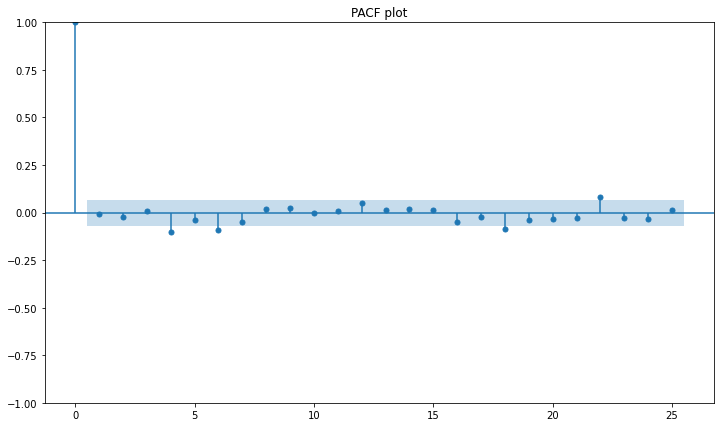

In [142]:
fig, ax = plt.subplots(figsize=(12, 7))
plot_pacf(df_train.diff().dropna(), lags = 25, title='PACF plot', ax=ax)
plt.show()

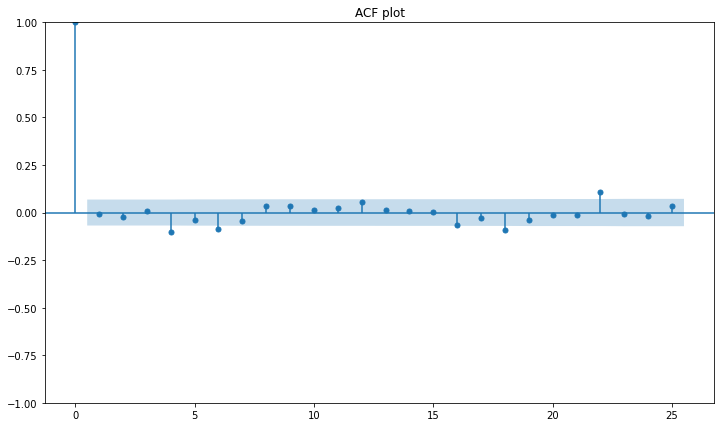

In [143]:
fig, ax = plt.subplots(figsize=(12, 7))
plot_acf(df_train.diff().dropna(), lags = 25, title='ACF plot', ax=ax)
plt.show()

### Automate the process of finding optimum parameters for ARIMA

In [40]:
import pmdarima as pm

In [153]:
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True)

In [154]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  826
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -3522.657
Date:                Tue, 20 Dec 2022   AIC                           7059.313
Time:                        21:15:27   BIC                           7092.321
Sample:                    01-02-2019   HQIC                          7071.975
                         - 03-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4005      0.270      1.484      0.138      -0.128       0.929
ar.L1          0.5880      0.119      4.942      0.000       0.355       0.821
ar.L2         -0.0194      0.029     -0.659      0.510      -0.077       0.038
ar.L3          0.0233      0.035      0.671      0.503      -0.045       0.092
ar.L4         -0.1095      0.035     -3.118      0.002      -0.178      -0.041
ma.L1         -0.6076      0.122     -4.972      0.000      -0.847      -0.368
sigma2       299.1102      9.119     32.801      0.000     281.237     316.983
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               952.63
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [157]:
X = values_sample.Gold.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [159]:
df_result_arima = pd.DataFrame({'Actual Data': [i.item() for i in test], 'Forecast': predictions})

In [160]:
df_result_arima

,Actual Data,Forecast
0,1934.4,1922.731200
1,1965.1,1935.269519
2,1993.9,1959.555657
3,2040.1,1992.590928
4,1985.9,2038.176876
...,...,...
202,1780.5,1798.377316
203,1813.9,1779.657104
204,1807.5,1812.749769
205,1777.2,1805.388671


In [162]:
df_result_arima.index = values_sample.iloc[-207:,:].index

In [163]:
df_result_arima

,Actual Data,Forecast
Date,,
2022-03-03,1934.4,1922.731200
2022-03-04,1965.1,1935.269519
2022-03-07,1993.9,1959.555657
2022-03-08,2040.1,1992.590928
2022-03-09,1985.9,2038.176876
...,...,...
2022-12-12,1780.5,1798.377316
2022-12-13,1813.9,1779.657104
2022-12-14,1807.5,1812.749769


In [182]:
df_result_arima.to_excel('Kết quả ARIMA.xlsx')

In [41]:
df_result_arima = pd.read_excel(r'C:\Users\ASUS\Desktop\Academic Activities\Hai môn học kỳ 5\Economic Forecasting\Kết quả ARIMA.xlsx', index_col=0)

In [42]:
df_result_arima

,Actual Data,Forecast
Date,,
2022-03-03,1934.4,1922.731200
2022-03-04,1965.1,1935.269519
2022-03-07,1993.9,1959.555657
2022-03-08,2040.1,1992.590928
2022-03-09,1985.9,2038.176876
...,...,...
2022-12-12,1780.5,1798.377316
2022-12-13,1813.9,1779.657104
2022-12-14,1807.5,1812.749769


In [43]:
MAE_arima = mean_absolute_error(df_result_arima['Actual Data'], df_result_arima['Forecast'])
RMSE_arima = np.sqrt(mean_squared_error(df_result_arima['Actual Data'], df_result_arima['Forecast']))
MAPE_arima = mean_absolute_percentage_error(df_result_arima['Actual Data'], df_result_arima['Forecast'])

# Step 5: ARIMAX model 

In [44]:
values_sample

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
Date,,,,,,,,,,,,,,,
2019-01-02,1281.0,15.54,46.54,2510.03,1355.91,122.19,106.12,799.1,2.62,96.42,23.22,35.88,1.15,910.35,6665.94
2019-01-03,1291.8,15.71,47.09,2447.89,1330.83,123.16,106.37,794.5,2.57,95.88,25.45,35.23,1.13,897.45,6463.50
2019-01-04,1282.7,15.69,47.96,2531.94,1380.75,122.30,106.16,822.0,2.65,95.75,21.38,36.36,1.14,921.30,6738.86
2019-01-07,1286.8,15.67,48.52,2549.69,1405.37,122.05,106.08,818.4,2.64,95.23,21.40,36.45,1.14,919.66,6823.47
2019-01-08,1283.2,15.63,49.78,2574.41,1426.55,121.75,105.95,816.5,2.66,95.48,20.47,36.58,1.15,929.30,6897.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,1780.5,23.22,73.17,3990.56,1818.61,113.59,102.47,1021.0,3.80,105.10,25.00,38.32,1.05,1269.15,11143.74
2022-12-13,1813.9,23.80,75.39,4019.65,1832.36,114.53,102.80,1051.9,3.84,103.94,22.55,38.59,1.05,1289.30,11256.81
2022-12-14,1807.5,23.95,77.28,3995.32,1820.45,114.45,102.82,1051.7,3.88,103.74,21.14,38.61,1.06,1285.98,11170.89


In [45]:
values_sample.columns

Index(['Gold', 'Silver', 'Crude Oil', 'S&P500', 'Russel 2000 Index',
       '10 Yr US T-Note futures', '2 Yr US T-Note Futures', 'Platinum',
       'Copper', 'Dollar Index', 'Volatility Index', 'MSCI EM ETF', 'Euro USD',
       'Euronext100', 'Nasdaq'],
      dtype='object')

In [46]:
inde_var = [
    'Silver', 'Crude Oil', 'S&P500', 'Russel 2000 Index',
       '10 Yr US T-Note futures', '2 Yr US T-Note Futures', 'Platinum',
       'Copper', 'Dollar Index', 'Volatility Index', 'MSCI EM ETF', 'Euro USD',
       'Euronext100', 'Nasdaq'
]

In [47]:
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28]

values_sample = values_sample.assign(**{
    f'{col} (lag-{lag})': values_sample[col].shift(lag)
    for lag in lags
    for col in inde_var
})

moving_average = [3, 5, 7, 14, 21, 28]  

values_sample = values_sample.assign(**{
    f'{col} (mva_{moving_average})': values_sample[col].shift(1).rolling(moving_average).mean()
    for moving_average in moving_average
    for col in inde_var
})

In [48]:
values_sample.dropna(inplace=True)

In [49]:
values_sample

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,...,10 Yr US T-Note futures (mva_28),2 Yr US T-Note Futures (mva_28),Platinum (mva_28),Copper (mva_28),Dollar Index (mva_28),Volatility Index (mva_28),MSCI EM ETF (mva_28),Euro USD (mva_28),Euronext100 (mva_28),Nasdaq (mva_28)
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-11,1307.0,15.66,52.41,2709.80,1518.98,122.12,106.08,782.7,2.79,96.86,...,121.864643,106.028571,807.460714,2.711786,95.661071,18.704643,37.883571,1.142500,949.866071,7060.904286
2019-02-12,1309.2,15.66,53.10,2744.73,1538.23,121.95,106.05,785.7,2.77,96.50,...,121.862143,106.027143,806.875000,2.717857,95.676786,18.445714,37.977143,1.141786,952.460714,7083.831429
2019-02-13,1310.8,15.62,53.90,2753.03,1542.94,121.75,105.97,788.0,2.77,96.94,...,121.818929,106.015714,806.560714,2.725000,95.698929,18.087857,38.105357,1.141786,955.764286,7117.800000
2019-02-14,1309.8,15.50,54.41,2745.73,1545.11,122.17,106.06,785.7,2.78,96.81,...,121.799286,106.008929,805.346429,2.729286,95.741429,17.883214,38.183214,1.141429,958.413571,7142.140000
2019-02-15,1318.1,15.72,55.59,2775.60,1569.25,122.05,106.01,803.4,2.80,96.74,...,121.803571,106.008214,804.178571,2.734286,95.797857,17.698214,38.260714,1.141071,961.001429,7163.692857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,1780.5,23.22,73.17,3990.56,1818.61,113.59,102.47,1021.0,3.80,105.10,...,112.518214,102.252857,1017.450000,3.722143,107.072143,22.725714,37.256429,1.026786,1256.835000,11038.743571
2022-12-13,1813.9,23.80,75.39,4019.65,1832.36,114.53,102.80,1051.9,3.84,103.94,...,112.624286,102.268214,1019.621429,3.732500,106.853214,22.695000,37.410357,1.028929,1259.510714,11060.848571
2022-12-14,1807.5,23.95,77.28,3995.32,1820.45,114.45,102.82,1051.7,3.88,103.74,...,112.785000,102.305000,1023.853571,3.746071,106.536786,22.596786,37.566786,1.031429,1263.188214,11093.486786


In [54]:
df_train_arimax = values_sample.iloc[:int(train_ratio*len(values_sample))]

In [55]:
SFA_corr = {}
for i in df_train_arimax.iloc[:, 1:].columns.tolist():
    corr = df_train_arimax[i].corr(df_train_arimax['Gold'])
    SFA_corr.update({i: corr})
    
SFA_corr = pd.DataFrame({
                        'Biến độc lập': SFA_corr.keys(),
                        'Hệ số tương quan': SFA_corr.values()
                          })

SFA_corr['Mức độ tác động'] = abs(SFA_corr['Hệ số tương quan'])
SFA_corr.sort_values(by='Mức độ tác động', ascending=False, inplace=True)
SFA_corr.reset_index(drop=True, inplace=True)

SFA_corr['Nhóm biến'] = SFA_corr['Biến độc lập'].str.split(pat = '(', expand = True)[0]
SFA_corr['Nhóm biến'] = SFA_corr['Nhóm biến'].str.strip()

In [56]:
SFA_corr = SFA_corr.loc[SFA_corr.groupby("Nhóm biến")["Mức độ tác động"].idxmax()]
SFA_corr.sort_values(by='Mức độ tác động', ascending=False, inplace=True)

In [57]:
SFA_corr

,Biến độc lập,Hệ số tương quan,Mức độ tác động,Nhóm biến
0,2 Yr US T-Note Futures (lag-28),0.917952,0.917952,2 Yr US T-Note Futures
17,Silver,0.852122,0.852122,Silver
28,10 Yr US T-Note futures (lag-28),0.811363,0.811363,10 Yr US T-Note futures
38,Nasdaq,0.750866,0.750866,Nasdaq
68,S&P500,0.646299,0.646299,S&P500
85,Euro USD,0.593553,0.593553,Euro USD
86,Dollar Index,-0.590432,0.590432,Dollar Index
109,MSCI EM ETF,0.566962,0.566962,MSCI EM ETF
119,Copper,0.557045,0.557045,Copper
149,Platinum,0.498998,0.498998,Platinum


In [58]:
inde_var_kept = ['2 Yr US T-Note Futures (lag-28)', 'Silver', 'Nasdaq', 'S&P500']

In [260]:
values_sample_arimax = values_sample.iloc[-251:]

In [261]:
df_train_arimax_temp = values_sample_arimax.iloc[0:44]

In [262]:
df_train_arimax_temp

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,...,10 Yr US T-Note futures (mva_28),2 Yr US T-Note Futures (mva_28),Platinum (mva_28),Copper (mva_28),Dollar Index (mva_28),Volatility Index (mva_28),MSCI EM ETF (mva_28),Euro USD (mva_28),Euronext100 (mva_28),Nasdaq (mva_28)
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,1827.5,23.33,75.21,4766.18,2245.31,130.47,109.46,964.4,4.45,95.59,...,131.001786,109.501786,946.435714,4.338571,96.252857,21.637500,47.558571,1.128571,1332.778929,15525.845714
2022-01-03,1799.4,22.79,76.08,4796.56,2272.56,129.44,108.98,953.7,4.41,96.21,...,131.026429,109.498214,946.482143,4.339643,96.220714,21.560357,47.528214,1.128929,1333.133214,15521.196786
2022-01-04,1814.0,23.04,76.99,4793.54,2268.87,129.28,109.02,970.4,4.47,96.27,...,131.012500,109.480357,945.746429,4.337857,96.197143,21.489643,47.512500,1.129643,1333.800000,15520.752857
2022-01-05,1824.6,23.15,77.85,4700.58,2194.00,128.84,108.89,1001.9,4.40,96.18,...,130.991071,109.464643,945.607143,4.339286,96.175714,21.430000,47.491071,1.130000,1334.559286,15512.806071
2022-01-06,1788.7,22.17,79.46,4696.05,2206.37,128.53,108.77,960.6,4.35,96.33,...,130.907857,109.435714,947.339286,4.343571,96.178571,21.112500,47.499643,1.130357,1337.565357,15498.824286
2022-01-07,1797.0,22.39,78.90,4677.03,2179.81,128.30,108.80,957.0,4.40,95.72,...,130.817857,109.401786,947.232143,4.343929,96.178214,20.992857,47.509286,1.130357,1339.448214,15473.753929
2022-01-10,1798.4,22.45,78.23,4670.29,2171.15,128.14,108.73,934.4,4.34,95.99,...,130.701786,109.369643,948.317857,4.348214,96.167857,20.691786,47.536071,1.130357,1341.727143,15452.261429
2022-01-11,1818.6,22.81,81.22,4713.07,2194.00,128.39,108.75,973.8,4.42,95.62,...,130.576786,109.337857,948.314286,4.351429,96.166786,20.273214,47.556429,1.130714,1342.342500,15441.146429
2022-01-12,1827.2,23.20,82.64,4726.35,2176.06,128.58,108.74,979.9,4.56,94.90,...,130.472500,109.310357,949.792857,4.355714,96.147500,19.932500,47.595714,1.130714,1344.110714,15433.008214


In [276]:
predictions = list()
# walk-forward validation
for t in range(207):
    df_train_arimax_temp = values_sample_arimax.iloc[0+t:44+t]
    SARIMAX_model = pm.auto_arima(df_train_arimax_temp[['Gold']], exogenous=df_train_arimax_temp[inde_var_kept],
                               start_p=1, start_q=1,
                               test='adf',
                               max_p=3, max_q=3, m=7,
                               start_P=0, seasonal=True,
                               d=None, D=1, 
                               trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    output = SARIMAX_model.predict(n_periods=1)
    predictions.append(output.values.item())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,1,0)[7]             : AIC=354.767, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[7]             : AIC=338.138, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,1,0)[7]             : AIC=348.810, Time=0.03 sec
 ARIMA(1,2,0)(2,1,0)[7]             : AIC=330.846, Time=0.10 sec
 ARIMA(1,2,0)(2,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(1,2,0)(1,1,1)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(2,1,0)[7]             : AIC=337.495, Time=0.08 sec
 ARIMA(2,2,0)(2,1,0)[7]             : AIC=319.469, Time=0.15 sec
 ARIMA(2,2,0)(1,1,0)[7]             : AIC=328.045, Time=0.10 sec
 ARIMA(2,2,0)(2,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(2,2,0)(1,1,1)[7]             : AIC=inf, Time=0.29 sec
 ARIMA(3,2,0)(2,1,0)[7]             : AIC=321.317, Time=0.14 sec
 ARIMA(2,2,1)(2,1,0)[7]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2

In [278]:
len(predictions)

207

In [289]:
df_result_sarimax = pd.DataFrame({'Actual Data': values_sample_arimax.iloc[44:44+207].Gold.values.tolist(), 'Forecast': predictions})

In [290]:
df_result_sarimax

,Actual Data,Forecast
0,1934.4,1942.234661
1,1965.1,1927.788442
2,1993.9,1954.207676
3,2040.1,2008.108816
4,1985.9,2069.467759
...,...,...
202,1780.5,1824.214112
203,1813.9,1775.091528
204,1807.5,1796.971759
205,1777.2,1821.359988


In [291]:
df_result_sarimax.to_excel('Ket qua SARIMAX.xlsx')

In [115]:
df_result_sarimax = pd.read_excel(r'Ket qua SARIMAX.xlsx', index_col=0)

In [116]:
MAE_sarimax = mean_absolute_error(df_result_sarimax['Actual Data'], df_result_sarimax['Forecast'])
RMSE_sarimax = np.sqrt(mean_squared_error(df_result_sarimax['Actual Data'], df_result_sarimax['Forecast']))
MAPE_sarimax = mean_absolute_percentage_error(df_result_sarimax['Actual Data'], df_result_sarimax['Forecast'])

# Step 6: Random Forest Regressor

In [133]:
values_spare = values_spare.iloc[1:,:]
values_spare = values_spare.pct_change()

In [137]:
values_spare

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
Date,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.000358,0.019495,0.003190,0.003116,-0.002515,0.005799,0.001386,0.008897,0.002950,0.000257,-0.034431,0.007344,0.000000,0.000832,0.000126
2010-01-06,0.015920,0.021372,0.017243,0.000546,-0.000846,-0.001979,0.000369,0.013980,0.023529,-0.002569,-0.009819,0.002126,0.000000,0.001003,-0.003301
2010-01-07,-0.002465,0.009361,-0.006252,0.004001,0.006301,-0.001121,-0.000553,0.000515,-0.020115,0.005924,-0.005219,-0.005759,-0.006944,-0.000730,-0.000452
2010-01-08,0.004501,0.007092,0.001089,0.002882,0.004034,0.001640,0.001199,0.007469,-0.005865,-0.005889,-0.048793,0.007927,0.006993,0.005188,0.007443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,-0.009788,-0.013175,0.030273,0.014279,0.012217,-0.002108,-0.000975,-0.026878,-0.020619,0.002863,0.095050,-0.002862,-0.009434,-0.004370,0.012642
2022-12-13,0.018759,0.024978,0.030340,0.007290,0.007561,0.008275,0.003220,0.030264,0.010526,-0.011037,-0.098000,0.007046,0.000000,0.015877,0.010147
2022-12-14,-0.003528,0.006303,0.025070,-0.006053,-0.006500,-0.000699,0.000195,-0.000190,0.010417,-0.001924,-0.062528,0.000518,0.009524,-0.002575,-0.007633


In [138]:
values_spare.dropna(inplace=True)

In [139]:
lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28]

values_spare = values_spare.assign(**{
    f'{col} (lag-{lag})': values_spare[col].shift(lag)
    for lag in lags
    for col in inde_var
})

moving_average = [3, 5, 7, 14, 21, 28]  

values_spare = values_spare.assign(**{
    f'{col} (mva_{moving_average})': values_spare[col].shift(1).rolling(moving_average).mean()
    for moving_average in moving_average
    for col in inde_var
})

In [141]:
values_spare

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,...,10 Yr US T-Note futures (mva_28),2 Yr US T-Note Futures (mva_28),Platinum (mva_28),Copper (mva_28),Dollar Index (mva_28),Volatility Index (mva_28),MSCI EM ETF (mva_28),Euro USD (mva_28),Euronext100 (mva_28),Nasdaq (mva_28)
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.000358,0.019495,0.003190,0.003116,-0.002515,0.005799,0.001386,0.008897,0.002950,0.000257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.015920,0.021372,0.017243,0.000546,-0.000846,-0.001979,0.000369,0.013980,0.023529,-0.002569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.002465,0.009361,-0.006252,0.004001,0.006301,-0.001121,-0.000553,0.000515,-0.020115,0.005924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.004501,0.007092,0.001089,0.002882,0.004034,0.001640,0.001199,0.007469,-0.005865,-0.005889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.010982,0.011918,-0.002779,0.001747,-0.000884,0.000000,0.000553,0.015148,0.011799,-0.006310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,-0.009788,-0.013175,0.030273,0.014279,0.012217,-0.002108,-0.000975,-0.026878,-0.020619,0.002863,...,0.001050,0.000165,0.003387,0.003792,-0.002132,-0.003414,0.004186,0.002480,0.002036,0.000586
2022-12-13,0.018759,0.024978,0.030340,0.007290,0.007561,0.008275,0.003220,0.030264,0.010526,-0.011037,...,0.000961,0.000151,0.002412,0.003056,-0.001988,-0.000089,0.004385,0.002143,0.002207,0.002238
2022-12-14,-0.003528,0.006303,0.025070,-0.006053,-0.006500,-0.000699,0.000195,-0.000190,0.010417,-0.001924,...,0.001447,0.000361,0.004489,0.003941,-0.002886,-0.002816,0.004427,0.002504,0.003011,0.003217


In [142]:
SFA_corr = {}
for i in values_spare.iloc[:,1:].columns.tolist():
    corr = values_spare[i].corr(values_spare['Gold'])
    SFA_corr.update({i: corr})
    
SFA_corr = pd.DataFrame({
                        'Biến độc lập': SFA_corr.keys(),
                        'Hệ số tương quan': SFA_corr.values()
                          })

SFA_corr['Mức độ tác động'] = abs(SFA_corr['Hệ số tương quan'])
SFA_corr.sort_values(by='Mức độ tác động', ascending=False, inplace=True)
SFA_corr.reset_index(drop=True, inplace=True)

SFA_corr['Nhóm biến'] = SFA_corr['Biến độc lập'].str.split(pat = '(', expand = True)[0]
SFA_corr['Nhóm biến'] = SFA_corr['Nhóm biến'].str.strip()

In [143]:
SFA_corr

,Biến độc lập,Hệ số tương quan,Mức độ tác động,Nhóm biến
0,Silver,0.802078,0.802078,Silver
1,Platinum,0.602939,0.602939,Platinum
2,Dollar Index,-0.359713,0.359713,Dollar Index
3,Copper,0.286272,0.286272,Copper
4,10 Yr US T-Note futures,0.258197,0.258197,10 Yr US T-Note futures
...,...,...,...,...
233,Euro USD (lag-6),-0.000558,0.000558,Euro USD
234,Euronext100 (lag-5),0.000356,0.000356,Euronext100
235,S&P500 (mva_7),-0.000214,0.000214,S&P500
236,S&P500 (lag-7),0.000203,0.000203,S&P500


In [153]:
values_spare.dropna(inplace=True)

In [154]:
x = values_spare.loc[:, values_spare.columns != 'Gold']

In [155]:
y = values_spare['Gold']

In [162]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [163]:
from sklearn.ensemble import RandomForestRegressor

In [164]:
rf = RandomForestRegressor(n_estimators = 500,
                           max_features = 'sqrt',
                           max_depth = 5,
                           random_state = 18).fit(x_train, y_train)

In [165]:
prediction = rf.predict(x_test)

In [166]:
prediction[:5]

array([ 0.0017809 , -0.0013635 ,  0.00148393, -0.00298804, -0.00055797])

In [167]:
len(prediction)

336

In [168]:
values_sample_rf = values_sample.loc[values_sample.index >= '2021-09-01']

In [169]:
values_sample.iloc[-337:].head()

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,...,10 Yr US T-Note futures (mva_28),2 Yr US T-Note Futures (mva_28),Platinum (mva_28),Copper (mva_28),Dollar Index (mva_28),Volatility Index (mva_28),MSCI EM ETF (mva_28),Euro USD (mva_28),Euronext100 (mva_28),Nasdaq (mva_28)
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-02,1808.7,23.88,69.99,4536.95,2304.02,134.12,110.32,993.9,4.29,92.23,...,134.141429,110.283571,1013.796429,4.332857,92.701071,17.564643,49.580714,1.177857,1302.905714,14852.413571
2021-09-03,1830.9,24.76,69.29,4535.43,2292.05,134.00,110.34,1021.2,4.33,92.03,...,134.138571,110.284643,1011.125000,4.322143,92.686071,17.522857,49.626429,1.178214,1304.657500,14869.930357
2021-09-06,1830.9,24.76,69.29,4535.43,2292.05,134.00,110.34,1021.2,4.33,92.03,...,134.121786,110.286071,1010.175000,4.314286,92.671429,17.417500,49.717500,1.178571,1306.403929,14895.035357
2021-09-07,1795.9,24.33,68.35,4520.03,2275.61,133.62,110.31,995.4,4.28,92.51,...,134.112143,110.287857,1008.928571,4.308929,92.661071,17.349643,49.761429,1.178929,1308.025000,14916.497500
2021-09-08,1790.7,24.01,69.30,4514.07,2249.73,133.86,110.31,975.3,4.23,92.65,...,134.090714,110.288214,1006.425000,4.300357,92.683929,17.365357,49.807143,1.178571,1309.268214,14937.785714


In [170]:
values_sample_rf

,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,...,10 Yr US T-Note futures (mva_28),2 Yr US T-Note Futures (mva_28),Platinum (mva_28),Copper (mva_28),Dollar Index (mva_28),Volatility Index (mva_28),MSCI EM ETF (mva_28),Euro USD (mva_28),Euronext100 (mva_28),Nasdaq (mva_28)
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-01,1813.1,24.18,68.59,4524.09,2287.06,134.05,110.32,1000.0,4.26,92.45,...,134.144643,110.282143,1015.925000,4.338214,92.718214,17.603571,49.561071,1.177857,1301.381429,14835.542500
2021-09-02,1808.7,23.88,69.99,4536.95,2304.02,134.12,110.32,993.9,4.29,92.23,...,134.141429,110.283571,1013.796429,4.332857,92.701071,17.564643,49.580714,1.177857,1302.905714,14852.413571
2021-09-03,1830.9,24.76,69.29,4535.43,2292.05,134.00,110.34,1021.2,4.33,92.03,...,134.138571,110.284643,1011.125000,4.322143,92.686071,17.522857,49.626429,1.178214,1304.657500,14869.930357
2021-09-06,1830.9,24.76,69.29,4535.43,2292.05,134.00,110.34,1021.2,4.33,92.03,...,134.121786,110.286071,1010.175000,4.314286,92.671429,17.417500,49.717500,1.178571,1306.403929,14895.035357
2021-09-07,1795.9,24.33,68.35,4520.03,2275.61,133.62,110.31,995.4,4.28,92.51,...,134.112143,110.287857,1008.928571,4.308929,92.661071,17.349643,49.761429,1.178929,1308.025000,14916.497500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,1780.5,23.22,73.17,3990.56,1818.61,113.59,102.47,1021.0,3.80,105.10,...,112.518214,102.252857,1017.450000,3.722143,107.072143,22.725714,37.256429,1.026786,1256.835000,11038.743571
2022-12-13,1813.9,23.80,75.39,4019.65,1832.36,114.53,102.80,1051.9,3.84,103.94,...,112.624286,102.268214,1019.621429,3.732500,106.853214,22.695000,37.410357,1.028929,1259.510714,11060.848571
2022-12-14,1807.5,23.95,77.28,3995.32,1820.45,114.45,102.82,1051.7,3.88,103.74,...,112.785000,102.305000,1023.853571,3.746071,106.536786,22.596786,37.566786,1.031429,1263.188214,11093.486786


In [176]:
len(values_sample_rf.Gold.iloc[-336:].values.tolist())

336

In [177]:
df_rf = pd.DataFrame({'Raw': values_sample_rf.Gold.iloc[-336:].values.tolist(),
             'Percentage change': prediction.tolist()})

In [178]:
df_rf

,Raw,Percentage change
0,1830.9,0.001781
1,1830.9,-0.001363
2,1795.9,0.001484
3,1790.7,-0.002988
4,1797.4,-0.000558
...,...,...
331,1780.5,0.003717
332,1813.9,0.001777
333,1807.5,-0.001766
334,1777.2,-0.002035


In [179]:
df_rf['Forecast'] = df_rf['Raw'] * (1 + df_rf['Percentage change'])

In [180]:
df_rf['Forecast_t+1'] = df_rf['Forecast'].shift(1)

In [181]:
df_rf.dropna(inplace=True)

In [182]:
df_rf

,Raw,Percentage change,Forecast,Forecast_t+1
1,1830.9,-0.001363,1828.403573,1834.160649
2,1795.9,0.001484,1798.564995,1828.403573
3,1790.7,-0.002988,1785.349312,1798.564995
4,1797.4,-0.000558,1796.397106,1785.349312
5,1789.6,0.002297,1793.710195,1796.397106
...,...,...,...,...
331,1780.5,0.003717,1787.118498,1804.209995
332,1813.9,0.001777,1817.123572,1787.118498
333,1807.5,-0.001766,1804.308209,1817.123572
334,1777.2,-0.002035,1773.584032,1804.308209


In [186]:
MAE_rf = mean_absolute_error(df_rf['Raw'], df_rf['Forecast_t+1'])
RMSE_rf = np.sqrt(mean_squared_error(df_rf['Raw'], df_rf['Forecast_t+1']))
MAPE_rf = mean_absolute_percentage_error(df_rf['Raw'], df_rf['Forecast_t+1'])

# Tổng hợp performance của các thuật toán

In [190]:
df_metrics = pd.DataFrame({'Phương pháp': [
                                           'Dự báo thô điều chỉnh xu thế',
                                           'Dự báo thô điều chỉnh xu thế', 
                                           'Dự báo thô điều chỉnh xu thế',
                                           'San mũ Holt',
                                           'San mũ Holt', 
                                           'San mũ Holt',
                                           'ARIMA',
                                           'ARIMA',
                                           'ARIMA',
                                           'SARIMAX',
                                           'SARIMAX',
                                           'SARIMAX',
    'Random Forest',
    'Random Forest',
    'Random Forest'
                                           ],
                           'Metrics': ['MAE',
                                       'RMSE',
                                       'MAPE',
                                       'MAE',
                                       'RMSE',
                                       'MAPE',
                                       'MAE',
                                       'RMSE',
                                       'MAPE',
                                       'MAE',
                                       'RMSE',
                                       'MAPE',
                                      'MAE',
                                       'RMSE',
                                       'MAPE'],
                           'Giá trị sai số': [
                                              MAE_tho_xu_the,
                                              RMSE_tho_xu_the,
                                              MAPE_tho_xu_the,
                                              MAE_holt,
                                              RMSE_holt,
                                              MAPE_holt,
                           MAE_arima,
                                              RMSE_arima,
                                              MAPE_arima,
                           MAE_sarimax,
                                              RMSE_sarimax,
                                              MAPE_sarimax,
                           MAE_rf,
                           RMSE_rf,
                           MAPE_rf]})

In [191]:
df_metrics

,Phương pháp,Metrics,Giá trị sai số
0,Dự báo thô điều chỉnh xu thế,MAE,19.643961
1,Dự báo thô điều chỉnh xu thế,RMSE,25.421885
2,Dự báo thô điều chỉnh xu thế,MAPE,0.010945
3,San mũ Holt,MAE,13.698513
4,San mũ Holt,RMSE,17.865323
5,San mũ Holt,MAPE,0.007619
6,ARIMA,MAE,13.201895
7,ARIMA,RMSE,17.591570
8,ARIMA,MAPE,0.007337
9,SARIMAX,MAE,18.065572


In [192]:
df_metrics['Giá trị sai số'] = df_metrics['Giá trị sai số'].round(4)

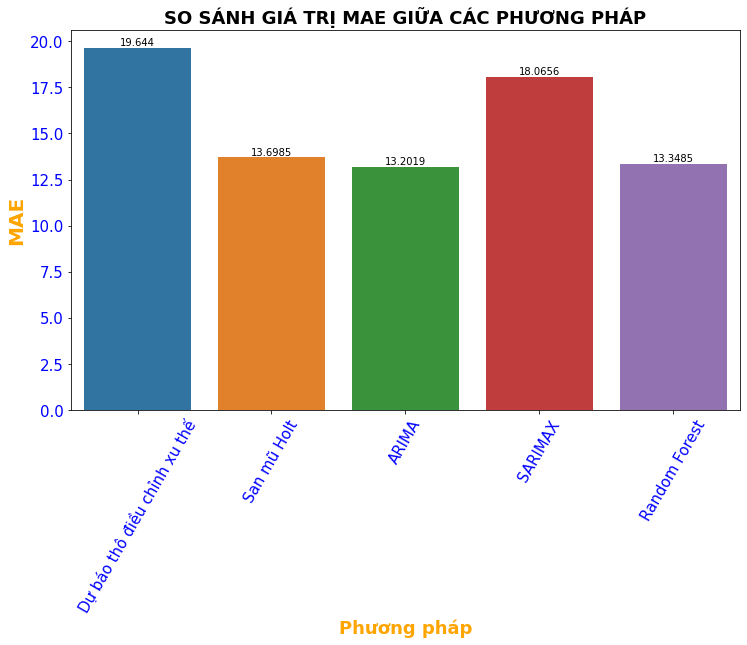

In [193]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Phương pháp', y='Giá trị sai số', data=df_metrics[df_metrics['Metrics'] == 'MAE']) 
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(color='blue', fontsize=15, rotation = 60)
plt.yticks(color='blue', fontsize=15)
plt.xlabel('Phương pháp', fontweight='bold', color = 'orange', fontsize='18')
plt.ylabel('MAE', fontweight='bold', color = 'orange', fontsize='20', rotation=90)
plt.title('SO SÁNH GIÁ TRỊ MAE GIỮA CÁC PHƯƠNG PHÁP', fontweight='bold', color = 'black', fontsize='18')
plt.show()

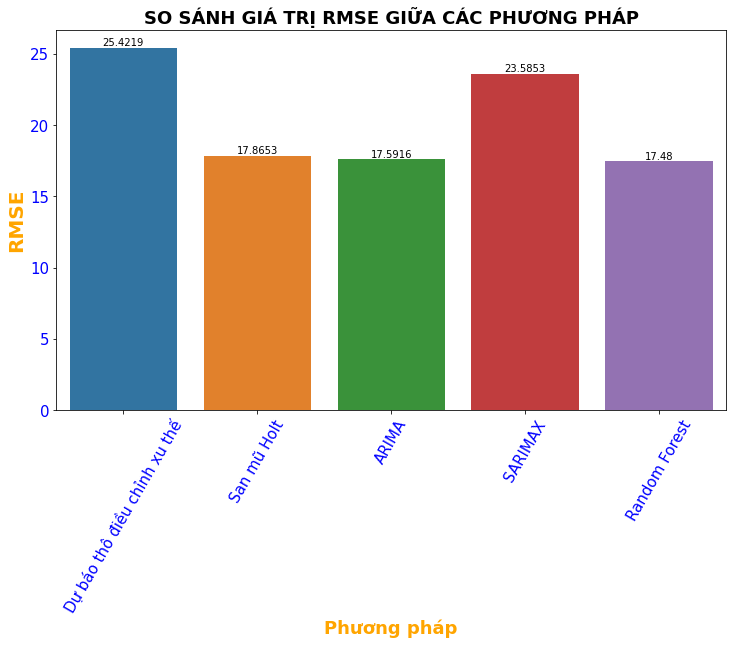

In [194]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Phương pháp', y='Giá trị sai số', data=df_metrics[df_metrics['Metrics'] == 'RMSE'])
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(color='blue', fontsize=15, rotation = 60)
plt.yticks(color='blue', fontsize=15)
plt.xlabel('Phương pháp', fontweight='bold', color = 'orange', fontsize='18')
plt.ylabel('RMSE', fontweight='bold', color = 'orange', fontsize='20', rotation=90)
plt.title('SO SÁNH GIÁ TRỊ RMSE GIỮA CÁC PHƯƠNG PHÁP', fontweight='bold', color = 'black', fontsize='18')
plt.show()

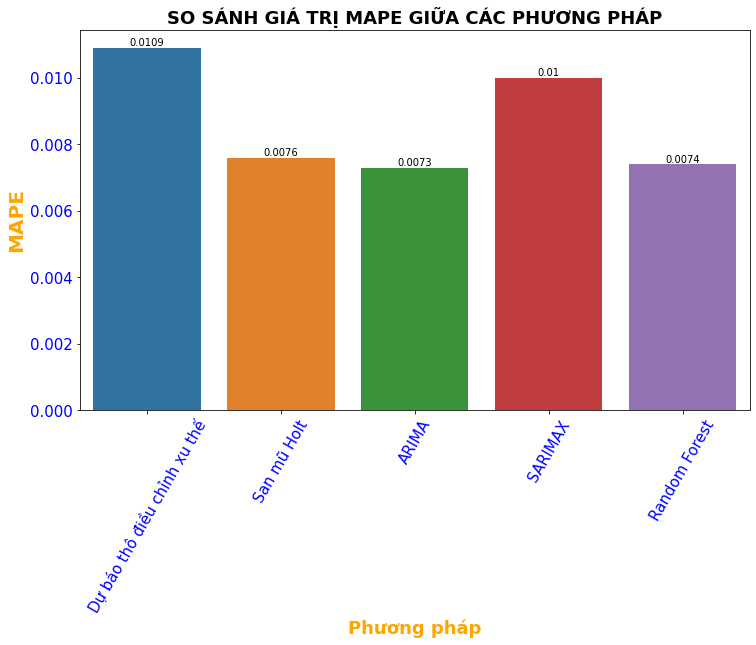

In [195]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Phương pháp', y='Giá trị sai số', data=df_metrics[df_metrics['Metrics'] == 'MAPE'])
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(color='blue', fontsize=15, rotation = 60)
plt.yticks(color='blue', fontsize=15)
plt.xlabel('Phương pháp', fontweight='bold', color = 'orange', fontsize='18')
plt.ylabel('MAPE', fontweight='bold', color = 'orange', fontsize='20', rotation=90)
plt.title('SO SÁNH GIÁ TRỊ MAPE GIỮA CÁC PHƯƠNG PHÁP', fontweight='bold', color = 'black', fontsize='18')
plt.show()